In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

all_data = {ticker: web.get_data_yahoo(ticker) for ticker in ['SPY', 'QQQ', 'XLF']}

spy_df = all_data['SPY']
qqq_df = all_data['QQQ']
xlf_df = all_data['XLF']


In [2]:
def volatility(df):
    return (df['High']- df['Low']) / df['Close']

def _delta(df):
    volume_delta = df['Volume'] - df['Volume'].shift(1)
    volat_delta = df['Volatility'] - df['Volatility'].shift(1)
    return volume_delta, volat_delta



spy_df['Volatility'] = volatility(spy_df)
qqq_df['Volatility'] = volatility(qqq_df)
xlf_df['Volatility'] = volatility(xlf_df)


spy_volume_delta, spy_vola_delta = _delta(spy_df)
spy_df['Volume_Delta'] = spy_volume_delta
spy_df['Volatility_Delta'] = spy_vola_delta


qqq_volume_delta, qqq_vola_delta = _delta(qqq_df)
qqq_df['Volume_Delta'] = qqq_volume_delta
qqq_df['Volatility_Delta'] = qqq_vola_delta


xlf_volume_delta, xlf_vola_delta = _delta(xlf_df)
xlf_df['Volume_Delta'] = xlf_volume_delta
xlf_df['Volatility_Delta'] = xlf_vola_delta

In [3]:
vola_df = pd.DataFrame({'SPY': spy_df['Volatility'], 'QQQ': qqq_df['Volatility'], 'XLF': xlf_df['Volatility']})

In [4]:
vola_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.925684,0.892033
QQQ,0.925684,1.000000,0.826748
XLF,0.892033,0.826748,1.000000


From the correlation we can see that QQQ and XLF have a fairly strong correlation with SPY and less so between each other. QQQ does have a slightly stronger correlation but only slight.

<AxesSubplot:xlabel='SPY'>

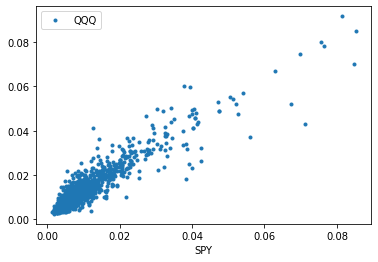

In [5]:
vola_df.plot(x='SPY', y='QQQ', style='.')

In [6]:
volume_df = pd.DataFrame({'SPY': spy_df['Volume'], 'QQQ': qqq_df['Volume'], 'XLF': xlf_df['Volume']})
volume_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.771802,0.694318
QQQ,0.771802,1.000000,0.611014
XLF,0.694318,0.611014,1.000000


We can see that volume has significantly less correlation than volatility. So we know that volume are not very related but we now do know that when one ETF is volatile others are typically volatile as well.

### Delta Comparison

In [7]:
vola_delta_df = pd.DataFrame({'SPY': spy_df['Volatility_Delta'], 'QQQ': qqq_df['Volatility_Delta'], 'XLF': xlf_df['Volatility_Delta']})

In [8]:
vola_delta_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.777166,0.616003
QQQ,0.777166,1.000000,0.520054
XLF,0.616003,0.520054,1.000000


In [9]:
volume_delta_df = pd.DataFrame({'SPY': spy_df['Volume_Delta'], 'QQQ': qqq_df['Volume_Delta'], 'XLF': xlf_df['Volume_Delta']})
volume_delta_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.740636,0.612764
QQQ,0.740636,1.000000,0.519069
XLF,0.612764,0.519069,1.000000


In the case of Delta volume vs volatility the correlations are more closely related.

#### Let us see if previous day volume / volatitility of the SPY can help us predict the volume / volatitity of another ETF such as QQQ

In [10]:

qqq_volume = volume_df[['SPY', 'QQQ']]
qqq_volume['prev_spy'] = qqq_volume['SPY'].shift(1)
qqq_volume.dropna(inplace=True)
qqq_volume.describe()

,SPY,QQQ,prev_spy
count,1.257000e+03,1.257000e+03,1.257000e+03
mean,9.114749e+07,3.579168e+07,9.122408e+07
std,4.972076e+07,2.116010e+07,4.975166e+07
min,2.027000e+07,7.079300e+06,2.027000e+07
25%,5.868260e+07,2.181550e+07,5.868260e+07
50%,7.723190e+07,2.986550e+07,7.732940e+07
75%,1.054429e+08,4.184990e+07,1.054797e+08
max,3.922207e+08,1.492471e+08,3.922207e+08


In [11]:
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

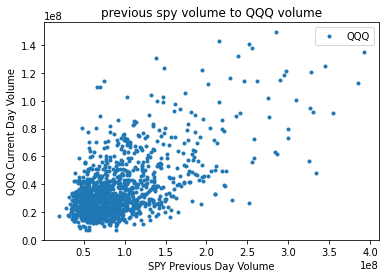

In [12]:
qqq_volume.plot(x='prev_spy', y='QQQ', style='.')
plt.title('previous spy volume to QQQ volume')  
plt.xlabel('SPY Previous Day Volume')  
plt.ylabel('QQQ Current Day Volume')  
plt.show()

In [13]:
X = qqq_volume['prev_spy'].values.reshape(-1,1)
y = qqq_volume['QQQ'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [15]:
print(regressor.intercept_)
print(regressor.coef_)

[12114260.48852874]
[[0.25791505]]


In [16]:
y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

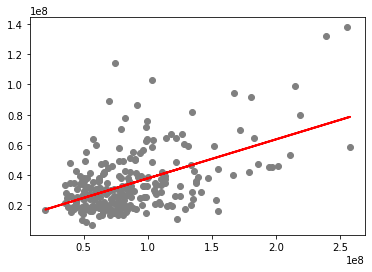

In [17]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 12565239.341337204
Mean Squared Error: 298700847562110.75
Root Mean Squared Error: 17282964.084962703
R-squared Error: 0.2736159078730319


#### Results
Looking at these results we can see the model does not do a very good job at explaing our data. Leveraging the previous day volume of the SPY does not yeild strong results for predicting tomorrows volume for the QQQ ETF. We have a very low (34%) R-squared and the MSE is very far from 0 indicating that this model is not very reliable. 

#### No lets try with volatility

In [19]:
qqq_vol = vola_df[['SPY', 'QQQ']]
qqq_vol['prev_spy'] = qqq_vol['SPY'].shift(1)
qqq_vol.dropna(inplace=True)
qqq_vol.describe()

,SPY,QQQ,prev_spy
count,1257.000000,1257.000000,1257.000000
mean,0.010721,0.013507,0.010721
std,0.009798,0.010432,0.009798
min,0.001229,0.002455,0.001229
25%,0.005056,0.006897,0.005056
50%,0.007720,0.010217,0.007720
75%,0.012472,0.016341,0.012472
max,0.085252,0.091672,0.085252


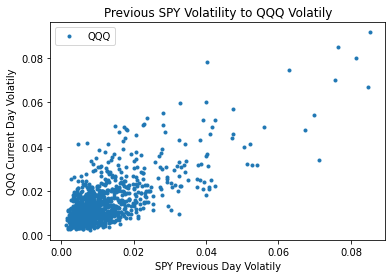

In [20]:
qqq_vol.plot(x='prev_spy', y='QQQ', style='.')
plt.title('Previous SPY Volatility to QQQ Volatily')  
plt.xlabel('SPY Previous Day Volatily')  
plt.ylabel('QQQ Current Day Volatily')  
plt.show()

In [21]:
X = qqq_vol['prev_spy'].values.reshape(-1,1)
y = qqq_vol['QQQ'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor.fit(X_train, y_train)

print(regressor.intercept_)
print(regressor.coef_)

y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

[0.00496124]
[[0.79126952]]


Mean Absolute Error: 0.0049801540269151555
Mean Squared Error: 5.610312471047968e-05
Root Mean Squared Error: 0.007490201913865853
R-squared Error: 0.42029799799808976


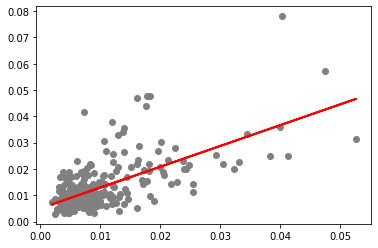

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

The results are slightly better than volume. We can see the R-squared Error is 46% which is better than the previous model but MSE is 5.9 which is fairly high given that the mean of all QQQ volatility is .01. This model definitely performs better but not by much. With the plot we can see the variation. 

#### Lets try a multiple regression and add in the previous day QQQ volatility and see if we can strengthen our prediction

In [23]:
qqq_vol = vola_df[['SPY', 'QQQ']]
qqq_vol['prev_spy'] = qqq_vol['SPY'].shift(1)
qqq_vol['prev_qqq'] = qqq_vol['QQQ'].shift(1)
qqq_vol.dropna(inplace=True)
qqq_vol.describe()

,SPY,QQQ,prev_spy,prev_qqq
count,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.010721,0.013507,0.010721,0.013502
std,0.009798,0.010432,0.009798,0.010429
min,0.001229,0.002455,0.001229,0.002455
25%,0.005056,0.006897,0.005056,0.006897
50%,0.007720,0.010217,0.007720,0.010217
75%,0.012472,0.016341,0.012472,0.016341
max,0.085252,0.091672,0.085252,0.091672


In [24]:
X = qqq_vol[['prev_spy', 'prev_qqq']].values
y = qqq_vol['QQQ'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, ['prev_spy', 'prev_qqq'], columns=['Coefficient'])  
coeff_df



,Coefficient
prev_spy,0.528305
prev_qqq,0.264745


In [25]:
y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
eval_data.head()

,Actual,Predicted
0,0.033939,0.015788
1,0.006018,0.008400
2,0.022677,0.014347
3,0.037843,0.014689
4,0.009698,0.008615


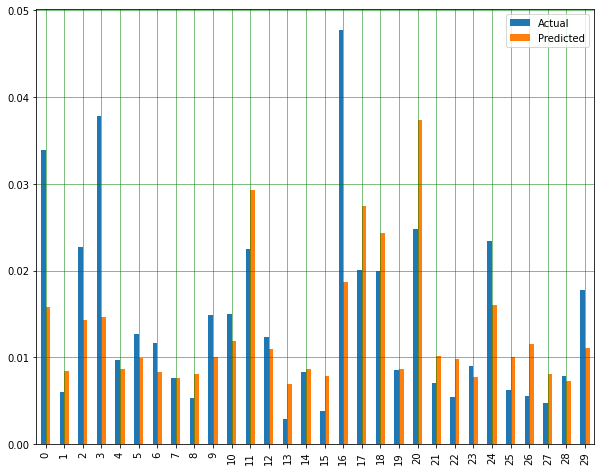

In [26]:
plot_data = eval_data.head(30)
plot_data.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.00483758115801375
Mean Squared Error: 5.309072872833521e-05
Root Mean Squared Error: 0.0072863384994340755
R-squared Error: 0.4514244636037651


- The Root Mean Squared Error is .007 which is about half of the mean .013
- The algorithm was not accurate and can be confirmed unreliable

The model did increase the R-squared Error by a slight amount from 46% to 48%and the MSE did decline by .02 so this is a stronger model than the previous single regression model but not enough to consider reliable

### Going to turn attention on to stocks Tesla in particular vs  Amazon

In [55]:
tsla = {'TSLA': web.get_data_yahoo('TSLA')}
tsla_df = tsla['TSLA']

amzn = {'AMZN': web.get_data_yahoo('AMZN')}
amzn_df = amzn['AMZN']

tsla_df['Volatility'] = volatility(tsla_df)
amzn_df['Volatility'] = volatility(amzn_df)

tsla_volume_delta, tsla_vola_delta = _delta(tsla_df)
tsla_df['Volume_Delta'] = tsla_volume_delta
tsla_df['Volatility_Delta'] = tsla_vola_delta

amzn_volume_delta, amzn_vola_delta = _delta(amzn_df)
amzn_df['Volume_Delta'] = amzn_volume_delta
amzn_df['Volatility_Delta'] = amzn_vola_delta

In [56]:
tsla_df.corr()

,High,Low,Open,Close,Volume,Adj Close,Volatility,Volume_Delta,Volatility_Delta
High,1.000000,0.998722,0.999129,0.999202,0.467453,0.999202,0.390362,0.005643,0.015617
Low,0.998722,1.000000,0.998831,0.998949,0.451334,0.998949,0.356030,-0.007825,-0.007964
Open,0.999129,0.998831,1.000000,0.998074,0.458165,0.998074,0.376230,-0.004065,0.005183
Close,0.999202,0.998949,0.998074,1.000000,0.459087,1.000000,0.373015,0.001289,0.008161
Volume,0.467453,0.451334,0.458165,0.459087,1.000000,0.459087,0.630607,0.355378,0.210807
Adj Close,0.999202,0.998949,0.998074,1.000000,0.459087,1.000000,0.373015,0.001289,0.008161
Volatility,0.390362,0.356030,0.376230,0.373015,0.630607,0.373015,1.000000,0.294750,0.466448
Volume_Delta,0.005643,-0.007825,-0.004065,0.001289,0.355378,0.001289,0.294750,1.000000,0.612686
Volatility_Delta,0.015617,-0.007964,0.005183,0.008161,0.210807,0.008161,0.466448,0.612686,1.000000


I am going to attempt to see if we can predict tomorrows close is higher or lower than the current days. I am going to make it a binary classification.

- 1 : will signal that the close will be higher
- 0 : will signal that the close will be lower

In [79]:
tsla_df['prev_close'] = tsla_df['Close'].shift(1)

def return_binary(row):
    if row['Close'] > row['prev_close']:
        return 1
    else:
        return 0
    
tsla_df['tomorrow_close'] = tsla_df.apply(lambda row: return_binary(row), axis=1)

In [78]:
tsla_df.dropna(inplace=True)
print('Higher: ', len([item for item in tsla_df['tomorrow_close'] if item == 1]))
print('Lower: ', len([item for item in tsla_df['tomorrow_close'] if item == 0]))

Higher:  645
Lower:  611


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = tsla_df[['High', 'Low', 'Open', 'prev_close', 'Volume']]
y = tsla_df['tomorrow_close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [68]:
predictions = logmodel.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [69]:

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.57      1.00      0.73       216

    accuracy                           0.57       378
   macro avg       0.29      0.50      0.36       378
weighted avg       0.33      0.57      0.42       378



c:\users\andrew\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


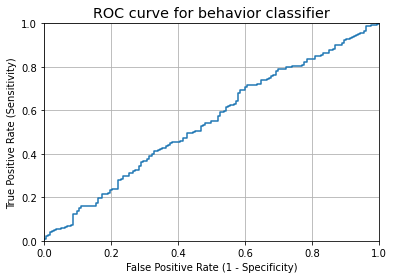

In [54]:
probs_y=logmodel.predict_proba(X_test) 

fpr, tpr, thresholds = metrics.roc_curve(y_test,probs_y[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for behavior classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Obviously the results are fairly poor with an F-1 of 57%. All of the predictions fall to 1 which the algo is thinking it the price will close to higher than the day previous. The dataset is fairly balanced between the two classes. We also see the the ROC curve is not actually a curve but a straight line. This also backs up the poor performance of the model. 